In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
# tf.keras.backend.set_floatx(
#     'float32'
# )
import numpy as np
import seaborn as sns; 
tfd = tf.contrib.distributions
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm

tfk = tf.keras

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0


In [2]:
tol = 1e-35
bs = 500
K = 3
do = .8
n_posterior_samples = 500

def ratios_critic(x, prob = 1, reuse=False, training = True):
    with tf.variable_scope('critic') as scope:
      if reuse:
        scope.reuse_variables()
      x = tf.expand_dims(x,1)
      h = slim.fully_connected(x, 100, activation_fn=tf.nn.softplus)
      h = tf.nn.dropout(h,prob)
      h = slim.fully_connected(h, 50, activation_fn=tf.nn.softplus)
      h = tf.nn.dropout(h,prob)
      log_d = slim.fully_connected(h, K, activation_fn=None)
    return h #tf.squeeze(log_d)






In [20]:
tf.reset_default_graph()
tf.random.set_random_seed(40)

# layer = tfk.layers.Dense(K, activation=None)

layer = tfp.layers.DenseFlipout(K, activation=None)

mu_1 = 0.
mu_2 = 4.
mu_3 = 4.
scale_pq = .1
scale_m = 2.
lam = tf.placeholder('float',1)
p = tfd.Normal(loc=mu_1, scale=scale_pq)
q = tfd.Normal(loc=mu_2, scale=scale_pq)
base = tfp.distributions.Cauchy(loc=mu_3, scale=scale_m)


samples = base.sample([bs]) 
p_samples = p.sample([bs]) 
q_samples = q.sample([bs])
m_samples = samples
# m_samples = samples + (p_samples+q_samples)/2.
m_samples2 = m_samples# samples[bs:]

#Ratio by log of prob evaluated at samples from base
log_ratio_p_q = p.log_prob(m_samples) - q.log_prob(m_samples)
#KL from samples
kld_from_samples = tf.reduce_mean(p.log_prob(p_samples) - q.log_prob(p_samples)) 
#KL from samples
kld = p.kl_divergence(q)


In [21]:
# Build 2 Discriminator Networks (one from noise input, one from generated samples)

disc_real = layer(ratios_critic(p_samples, do))
disc_fake = layer(ratios_critic(q_samples, do,reuse=True))
disc_m = layer(ratios_critic(m_samples, do,reuse=True))
# disc_m_gen = ratios_critic(m_samples2, do,reuse=True)

# Build Loss
# lab = np.eye(K)
# a = np.tile(lab[0],bs)
# b = np.tile(lab[1],bs)
# c = np.tile(lab[2],bs)

a = np.tile([1,0,0],bs)
b = np.tile([0,1,0],bs)
c = np.tile([0,0,1],bs)

label_a = tf.reshape(a,[bs,K])
label_b = tf.reshape(b,[bs,K])
label_c = tf.reshape(c,[bs,K])


disc_loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_real, labels=label_a))
disc_loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_fake, labels=label_b))
disc_loss_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m, labels=label_c))
# disc_loss_4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m_gen, labels=label_c))

dloss_ = disc_loss_1 + disc_loss_2 + 1*disc_loss_3 #+ 0.5*disc_loss_4 
kl_loss = sum(layer.losses)/1e+5
dloss = dloss_ + kl_loss
# Define CoB DRE

log_r_p_m = layer(ratios_critic(m_samples, reuse=True, training=False))
log_r_p_from_m_direct = log_r_p_m 

#KL from samples
ratio_logits = layer(ratios_critic(p_samples, reuse=True, training=False))
kld_from_cob = tf.reduce_mean(ratio_logits[:,0] - ratio_logits[:,1]) 

enc_m = ratios_critic(m_samples, reuse=True, training=False)
enc_p = ratios_critic(p_samples, reuse=True, training=False)

t_vars = tf.trainable_variables()
c_vars = [var for var in t_vars if 'critic' in var.name]

c_optim = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.001, beta2=0.999).minimize(dloss, var_list=t_vars)

init = tf.global_variables_initializer()
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)


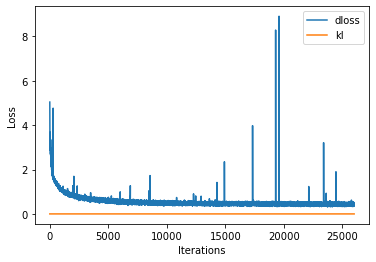

In [22]:
# Training
loss1 = []
loss2 = []
pbar = (range(0,26000))
for i in tqdm(pbar):
    # Train
    feed_dict = {}
    l1, l2, _ = sess.run([dloss_, kl_loss, c_optim],feed_dict=feed_dict)
    loss1.append(l1)
    loss2.append(l2)

fig = plt.figure()
ax = plt.axes()
plt.plot(loss1, label='dloss')
plt.plot(loss2, label='kl')
ax.set_xlabel('Iterations' )
ax.set_ylabel('Loss')
plt.legend(loc='upper right')

KL :  799.99994
KL from samples :  803.2071
KL from CoB:  796.9083


(-5.0, 5.0)

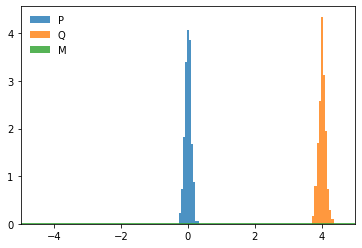

In [23]:
# Sampling
kl_ratio_store=[]
log_ratio_store=[]
log_r_p_from_m_direct_store=[]


feed_dict = feed_dict
kl_ratio, kl_cob, kl_ture, p_s, q_s, d_s, m_s, lpq, lpq_from_cob_dre_direct= sess.run([kld_from_samples, kld_from_cob, kld,
                                                                            p_samples, q_samples, enc_m, m_samples,
                                                                            log_ratio_p_q,  log_r_p_from_m_direct],
                                                                          feed_dict=feed_dict)
print('KL : ',kl_ture)
print('KL from samples : ',kl_ratio)
print('KL from CoB: ', kl_cob)
log_ratio_store.append(lpq)
log_r_p_from_m_direct_store.append(lpq_from_cob_dre_direct)
    
fig, ax = plt.subplots(1, 1)
ax.hist(p_s, density=True, histtype='stepfilled', alpha=0.8, label='P')
ax.hist(q_s, density=True, histtype='stepfilled', alpha=0.8, label='Q')
# ax.hist(d_s, density=True, histtype='stepfilled', alpha=0.8, label='M')
ax.hist(m_s, density=True, histtype='stepfilled', alpha=0.8, label='M')
ax.legend(loc='best', frameon=False)
plt.xlim(-5,5)
# plt.ylim(-400,800)

(-400.0, 1000.0)

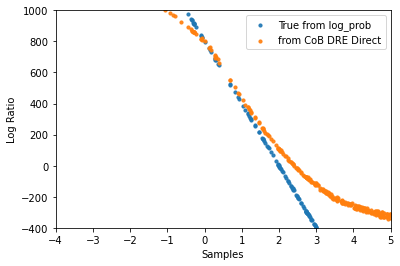

In [24]:
xs = m_s
plt.scatter(xs,log_ratio_store[0],label='True from log_prob',alpha=0.9,s=10.)
plt.scatter(xs,log_r_p_from_m_direct_store[-1][:,0]-log_r_p_from_m_direct_store[-1][:,1],label='from CoB DRE Direct',alpha=0.9,s=10.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-4,5)
plt.ylim(-400,1000)

(-400.0, 1000.0)

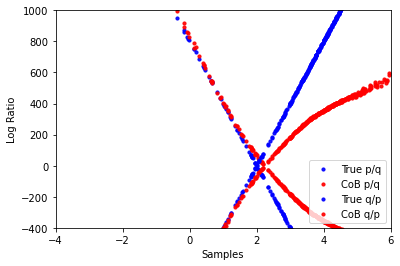

In [15]:
plt.scatter(xs,log_ratio_store[0],label='True p/q',alpha=0.9,s=10.,c='b')
plt.scatter(xs,log_r_p_from_m_direct_store[-1][:,0]-log_r_p_from_m_direct_store[-1][:,1],label='CoB p/q',alpha=0.9,s=10.,c='r')
plt.scatter(xs,-log_ratio_store[0],label='True q/p',alpha=0.9,s=10.,c='b')
plt.scatter(xs,log_r_p_from_m_direct_store[-1][:,1]-log_r_p_from_m_direct_store[-1][:,0],label='CoB q/p',alpha=0.9,s=10.,c='r')

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='lower right')
plt.xlim(-4,6)
plt.ylim(-400,1000)

(-4000.0, 400.0)

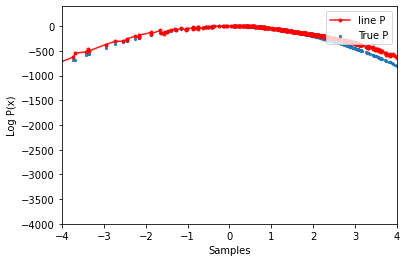

In [9]:
rat = log_r_p_from_m_direct_store[-1][:,0]-log_r_p_from_m_direct_store[-1][:,1]
d = [np.squeeze(norm.logpdf(x,mu_2,scale_pq)) for x in xs]
b = [np.squeeze(norm.logpdf(x,mu_1,scale_pq)) for x in xs]

plt.scatter(xs,b,label='True P',alpha=0.9,s=5.)
# plt.scatter(xs,rat+d,label='P',alpha=0.9,s=5.)
x_sorted = []
r_sorted = []
[(x_sorted.append(a),r_sorted.append(b)) for a,b in sorted(zip(xs,rat+d))]
plt.plot(x_sorted, r_sorted, '-r.', label='line P',alpha=0.9)

plt.xlabel("Samples")
plt.ylabel("Log P(x)")
plt.legend(loc='upper right')
plt.xlim(-4.,4)
plt.ylim(-4000,400)

In [10]:
# helper function, mostly for plotting
def log_ratio(w, b):
  [x_] = sess.run([enc_m],feed_dict={})
  return x_@w + b

def log_ratio_predictive(w, b):
  x_ = d_s
  print(x_.shape)
  print(w.shape)
  pred = x_@w 
  # pred = np.transpose(pred,(1,0,2))+ b
  pred = pred[0,:,:] - pred[1,:,:]
  print(pred.shape)
  return pred.mean(1), (pred).std(1)

def log_ratio_predictive_p(w, b):
  [x_] = sess.run([enc_p],feed_dict={})
  print(x_.shape)
  print(w.shape)
  pred = x_@w 
  # pred = np.transpose(pred,(1,0,2))+ b
  pred = pred[0,:,:] - pred[1,:,:]
  print(pred.shape)
  return pred.mean(1), (pred).std(1)

Taking 500 samples from posterior distributions on weights

Sampling complete. Samples are stored in numpy arrays:
  weight: candidate_ws
    bias: candidate_bs
(500, 100)
(3, 100, 500)
(500, 500)
(500,)
Done


(-400.0, 1000.0)

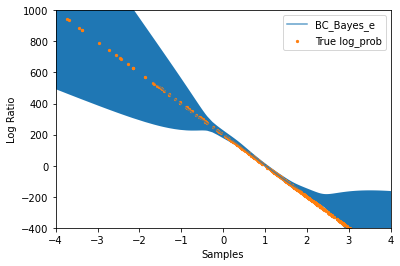

In [11]:
candidate_ws = []
candidate_bs = []

print(f"Taking {n_posterior_samples} samples from posterior distributions on weights\n")

w_draw = layer.kernel_posterior.sample()
b_draw = layer.bias_posterior.sample()

for mc in range(n_posterior_samples):
    w_, b_ = sess.run([w_draw, b_draw])
    candidate_ws.append(w_)
    candidate_bs.append(b_)
    
print("Sampling complete. Samples are stored in numpy arrays:")
print(f"  weight: candidate_ws")
print(f"    bias: candidate_bs")
        
candidate_ws = np.array(candidate_ws).astype(np.float32)
candidate_bs = np.array(candidate_bs).astype(np.float32)
# print(candidate_ws.shape)
# candidate_ws = np.transpose(candidate_ws, (1,2,0))
post_pred,post_std = log_ratio_predictive(candidate_ws.T, candidate_bs.T)
print(post_pred.shape)
# plt.plot(xs,post_pred,label='BC_Bayes_e',alpha=0.7)
x_sorted = []
m_sorted = []
s_sorted = []
[(x_sorted.append(a),m_sorted.append(b), s_sorted.append(c)) for a,b,c in sorted(zip(xs,post_pred, post_std))]
print('Done')
plt.plot(x_sorted, m_sorted,label='BC_Bayes_e',alpha=0.7)
# plt.scatter(xs,post_pred,label='BC_Bayes_e',alpha=0.7,s=5.)
plt.fill_between(x_sorted, np.asarray(m_sorted)-10*np.asarray(s_sorted), np.asarray(m_sorted)+10*np.asarray(s_sorted))

plt.scatter(xs,norm.logpdf(xs,mu_1,scale_pq)-norm.logpdf(xs,mu_2,scale_pq),label='True log_prob',alpha=0.99,s=5.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-4,4)
plt.ylim(-400,1000)

In [12]:
[true_kl] = sess.run([kld],feed_dict={})
print('KL : ',true_kl)
post_pred,post_std = log_ratio_predictive_p(candidate_ws.T, candidate_bs.T)
spp = [x for _,x in sorted(zip(post_std,post_pred))]
print('KL Post Pred: ', np.mean(spp[:500]))

KL :  199.99998
(500, 100)
(3, 100, 500)
(500, 500)
KL Post Pred:  202.23706
